In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.decomposition import PCA
from yellowbrick.features import PCA
from yellowbrick.classifier import ClassificationReport, ROCAUC
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [95]:
# for plot use
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray',
          'tab:olive','tab:cyan', 'c', 'm', 'y', 'r']

In [2]:
data = pd.read_csv("sample.csv")
data_Y = data[' Label']#.to_numpy().flatten()
data_X = data.drop(columns=['Unnamed: 0', 'Flow ID', ' Timestamp', ' Label'])
del data
gc.collect()

0

In [3]:
data_Y.value_counts()

TFTP       100000
BENIGN     100000
NTP        100000
NetBIOS    100000
SSDP       100000
MSSQL      100000
UDP        100000
DNS        100000
UDPLag     100000
Syn        100000
SNMP       100000
Portmap    100000
LDAP       100000
WebDDoS       439
Name:  Label, dtype: int64

### Feature Engineering

In [4]:
src_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Source IP']]
data_X[' Source IP'] = pd.Series(src_ip)

In [5]:
dst_ip = [int(''.join([bin(int(x)+256)[3:] for x in ip.split('.')]),2) for ip in data_X[' Destination IP']]
data_X[' Destination IP'] = pd.Series(dst_ip)

In [6]:
# do data_X['SimillarHTTP'].value_counts()
data_X['SimillarHTTP'][data_X['SimillarHTTP'] != 0] = 1      

In [7]:
# todo: scale before preprocessing
data_X['Flow Bytes/s'][np.isinf(data_X['Flow Bytes/s'])] = 9999999999
data_X['Flow Bytes/s'][data_X['Flow Bytes/s'].isna()] = data_X['Flow Bytes/s'].mean()

In [8]:
data_X[' Flow Packets/s'][np.isinf(data_X[' Flow Packets/s'])] = 5000000

### PCA

In [8]:
data_Y_num = data_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [31]:
labels = ['BENIGN', 'DNS', 'LDAP', 'MSSQL', 'NTP', 'NetBIOS', 'Portmap', 'SNMP',
               'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag', 'WebDDoS']

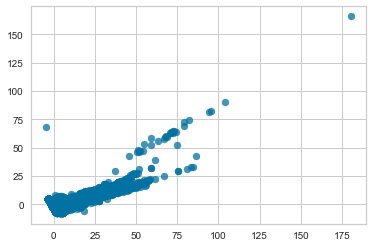

In [9]:
pca = PCA(n_components=2)
data_X_pca = pca.fit_transform(data_X)

In [10]:
data_X_pca[:5]

array([[-2.77630008,  4.50386267],
       [-1.98040137,  2.20505423],
       [-2.69884248,  4.47686262],
       [-2.52565847,  4.27083448],
       [-2.76824574,  4.50181562]])

## Train Test Split

In [9]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.2, random_state=1)

In [10]:
train_Y_num = train_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

In [11]:
test_Y_num = test_Y.replace({'BENIGN':0, 'DNS':1, 'LDAP':2, 'MSSQL':3, 'NTP':4, 'NetBIOS':5, 'Portmap':6, 'SNMP':7,
               'SSDP':8, 'Syn':9, 'TFTP':10, 'UDP':11, 'UDPLag':12, 'WebDDoS':13}).to_numpy().flatten()

## Standardizer

In [12]:
scaler = StandardScaler().fit(train_X)
train_X_std = scaler.transform(train_X)
test_X_std = scaler.transform(test_X)

## Feature Importance - Random Forest

In [130]:
rf = RandomForestClassifier(random_state=0)
model = rf.fit(train_X_std, train_Y_num)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

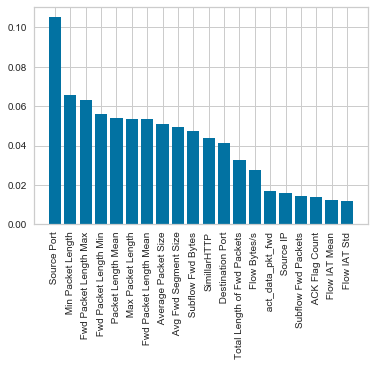

In [22]:
names = [data_X.columns[i] for i in indices]
plt.figure()
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), names[:20], rotation=90)
plt.show()

In [17]:
randomforest.score(train_X_std, train_Y)

0.8574298481954647

In [18]:
randomforest.score(test_X_std, test_Y)

0.7927163114022946

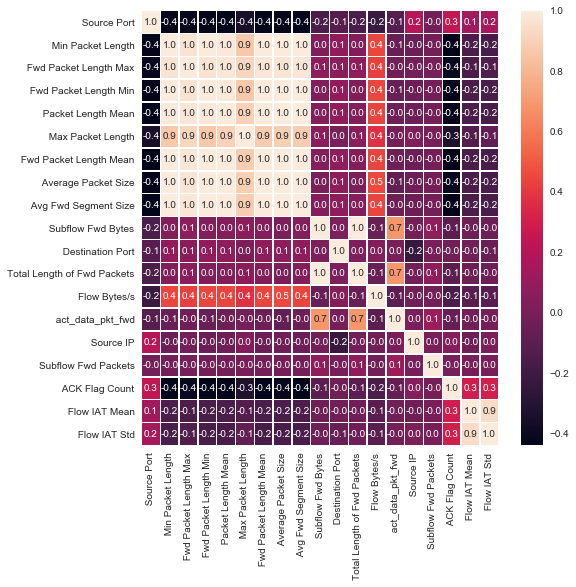

In [30]:
f,ax=plt.subplots(figsize=(8,8))
sns.heatmap(data_X[names[:20]].corr(),annot=True,linewidth=.5,fmt='.1f',ax=ax)
plt.show()

## Training

### Logistic Regression

In [61]:
lr = LogisticRegression(random_state=0).fit(train_X_std, train_Y_num)
lr.score(train_X_std, train_Y_num)

0.6853619595694146

In [62]:
lr.score(test_X_std, test_Y_num)

0.6859370674540924

In [83]:
test_Yhat = lr.predict(test_X_std)
cm = confusion_matrix(test_Y_num, test_Yhat)

Precision, Recall, F1

In [70]:
m_pr, m_rec, m_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='macro')
w_pr, w_rec, w_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='weighted')
print("\t\t\tMacro\t\tWeightened")
print("Precision:\t", m_pr, w_pr)
print("Recall:\t\t", m_rec, w_rec)
print("F1:\t\t", m_f1, w_f1)

			Macro		Weightened
Precision:	 0.6933001794827023 0.7180394817161635
Recall:		 0.6432106835370481 0.6859370674540924
F1:		 0.6294975232127415 0.6667950744429348


Confusion Matrix

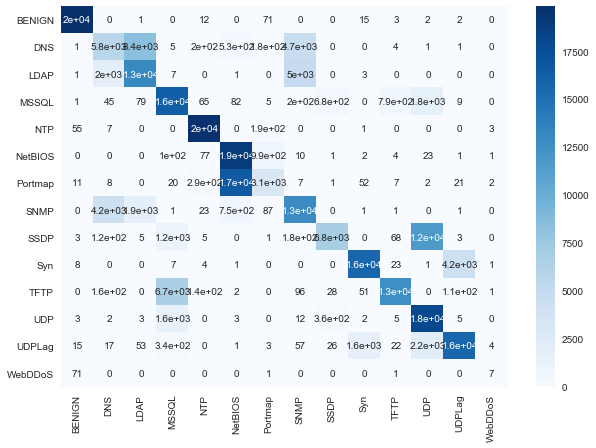

In [37]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', linecolor='white')

Classification Report

In [94]:
print(classification_report(test_Y_num, test_Yhat, target_names=labels))

              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99     19943
         DNS       0.47      0.29      0.36     19862
        LDAP       0.55      0.65      0.60     20104
       MSSQL       0.62      0.81      0.70     19989
         NTP       0.96      0.99      0.97     19991
     NetBIOS       0.51      0.94      0.66     20169
     Portmap       0.67      0.15      0.25     20087
        SNMP       0.56      0.65      0.60     19822
        SSDP       0.86      0.34      0.49     20058
         Syn       0.90      0.79      0.84     20015
        TFTP       0.93      0.63      0.75     19821
         UDP       0.54      0.90      0.67     20043
      UDPLag       0.78      0.78      0.78     20104
     WebDDoS       0.37      0.09      0.14        80

    accuracy                           0.69    260088
   macro avg       0.69      0.64      0.63    260088
weighted avg       0.72      0.69      0.67    260088



ROC/AUC Curve

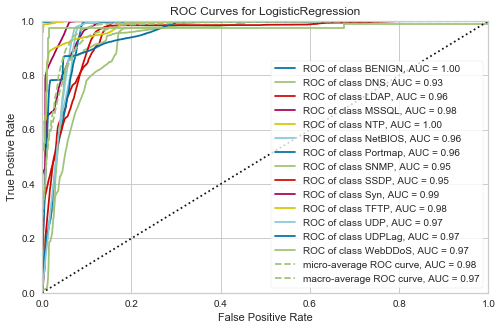

In [52]:
plt.figure(figsize = (8,5))
rocauc = ROCAUC(lr, classes=labels)
rocauc.fit(train_X_std, train_Y_num)
rocauc.score(test_X_std, test_Y_num)
rocauc.poof()

### Random Forest

In [133]:
rf.score(train_X_std, train_Y_num)

0.8574298481954647

In [132]:
rf.score(test_X_std, test_Y_num)

0.7927163114022946

In [137]:
test_Yhat = rf.predict(test_X_std)
cm = confusion_matrix(test_Y_num, test_Yhat)

Precision, Recall, F1

In [138]:
m_pr, m_rec, m_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='macro')
w_pr, w_rec, w_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='weighted')
print("\t\t\tMacro\t\tWeightened")
print("Precision:\t", m_pr, w_pr)
print("Recall:\t\t", m_rec, w_rec)
print("F1:\t\t", m_f1, w_f1)

			Macro		Weightened
Precision:	 0.7999810711528762 0.8085771184908653
Recall:		 0.7881666918022366 0.7927163114022946
F1:		 0.7825158626793309 0.7882293641633586


Confusion Matrix

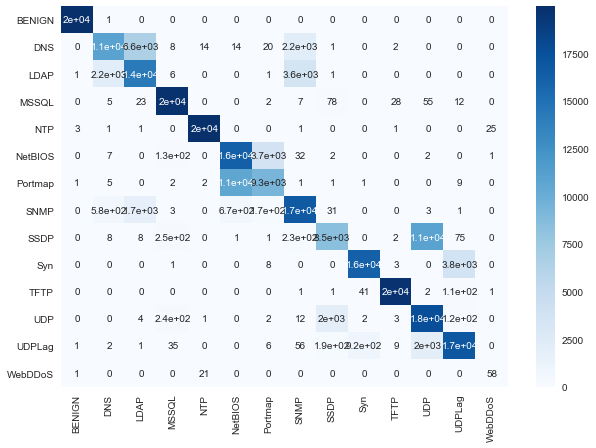

In [139]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', linecolor='white')

Classification Report

In [140]:
print(classification_report(test_Y_num, test_Yhat, target_names=labels))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19943
         DNS       0.80      0.55      0.65     19862
        LDAP       0.63      0.71      0.67     20104
       MSSQL       0.97      0.99      0.98     19989
         NTP       1.00      1.00      1.00     19991
     NetBIOS       0.59      0.81      0.68     20169
     Portmap       0.70      0.46      0.56     20087
        SNMP       0.73      0.84      0.78     19822
        SSDP       0.78      0.42      0.55     20058
         Syn       0.94      0.81      0.87     20015
        TFTP       1.00      0.99      0.99     19821
         UDP       0.57      0.88      0.69     20043
      UDPLag       0.80      0.84      0.82     20104
     WebDDoS       0.68      0.72      0.70        80

    accuracy                           0.79    260088
   macro avg       0.80      0.79      0.78    260088
weighted avg       0.81      0.79      0.79    260088



ROC/AUC Curve

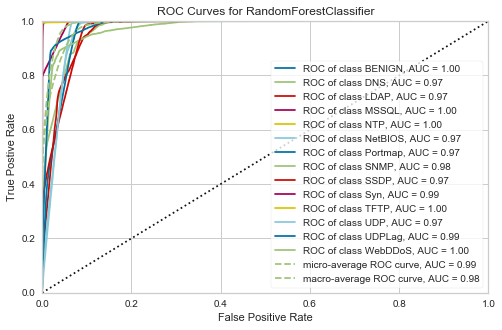

In [141]:
plt.figure(figsize = (8,5))
rocauc = ROCAUC(rf, classes=labels)
rocauc.fit(train_X_std, train_Y_num)
rocauc.score(test_X_std, test_Y_num)
rocauc.poof()

### NN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [15]:
train_X.shape

(1040351, 84)

In [ ]:
nn = Sequential()
nn.add(Dense(84, activation='relu', input_shape=(84,)))
nn.add(Dropout(0.2))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.2))
nn.add(Dense(14, activation='softmax'))
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], 
            validation_data=(test_X_std, test_Y_num))

In [102]:
network = KerasClassifier(build_fn=make_network, epochs=100, batch_size=1500, verbose=0)

In [17]:
history = nn.fit(x=train_X_std, y=train_Y_num, epochs=100, batch_size=1500)

Train on 1040351 samples
Epoch 1/100
1040351/1040351 [==============================] - 21s 20us/sample - loss: 0.8400 - accuracy: 0.6378
Epoch 2/100
1040351/1040351 [==============================] - 22s 21us/sample - loss: 0.6523 - accuracy: 0.6960
Epoch 3/100
1040351/1040351 [==============================] - 22s 21us/sample - loss: 0.6108 - accuracy: 0.7116
Epoch 4/100
1040351/1040351 [==============================] - 21s 20us/sample - loss: 0.5893 - accuracy: 0.7198
Epoch 5/100
1040351/1040351 [==============================] - 23s 23us/sample - loss: 0.5767 - accuracy: 0.7253
Epoch 6/100
1040351/1040351 [==============================] - 24s 23us/sample - loss: 0.5674 - accuracy: 0.7301
Epoch 7/100
1040351/1040351 [==============================] - 22s 21us/sample - loss: 0.5583 - accuracy: 0.7381
Epoch 8/100
1040351/1040351 [==============================] - 31s 30us/sample - loss: 0.5452 - accuracy: 0.7478
Epoch 9/100
1040351/1040351 [==============================] - 23s 22us

In [18]:
nn.save('nn_model_100.h5')

In [19]:
nn.evaluate(test_X_std, test_Y_num)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.4887685823561921, 0.7686091]

Precision, Recall, F1

In [106]:
m_pr, m_rec, m_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='macro')
w_pr, w_rec, w_f1, _ = precision_recall_fscore_support(test_Y_num, test_Yhat, average='weighted')
print("\t\t\tMacro\t\tWeightened")
print("Precision:\t", m_pr, w_pr)
print("Recall:\t\t", m_rec, w_rec)
print("F1:\t\t", m_f1, w_f1)

			Macro		Weightened
Precision:	 0.7875570701701766 0.8020607501133442
Recall:		 0.78104712304405 0.7678093568330718
F1:		 0.7494688267938935 0.7504718753271246


Confusion Matrix

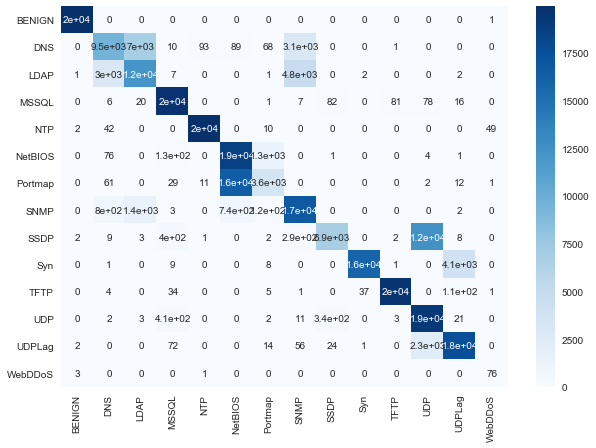

In [107]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', linecolor='white')

Classification Report

In [128]:
print(classification_report(test_Y_num, test_Yhat, target_names=labels))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19943
         DNS       0.70      0.48      0.57     19862
        LDAP       0.59      0.61      0.60     20104
       MSSQL       0.95      0.99      0.97     19989
         NTP       0.99      0.99      0.99     19991
     NetBIOS       0.52      0.93      0.67     20169
     Portmap       0.70      0.18      0.29     20087
        SNMP       0.67      0.85      0.75     19822
        SSDP       0.94      0.34      0.50     20058
         Syn       1.00      0.80      0.89     20015
        TFTP       1.00      0.99      0.99     19821
         UDP       0.56      0.96      0.71     20043
      UDPLag       0.81      0.88      0.84     20104
     WebDDoS       0.59      0.95      0.73        80

    accuracy                           0.77    260088
   macro avg       0.79      0.78      0.75    260088
weighted avg       0.80      0.77      0.75    260088



Loss, Accuracy / Epochs

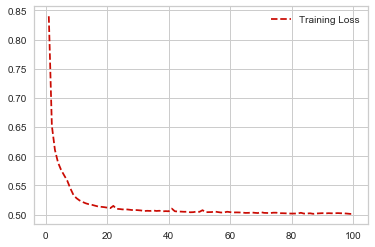

In [20]:
training_loss = history.history['loss']
#test_loss = history.history['accuracy']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])

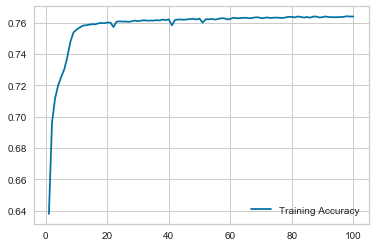

In [21]:
#training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
epoch_count = range(1, len(training_loss) + 1)
#plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_accuracy, 'b-')
plt.legend(['Training Accuracy'])

In [1]:
from keras.models import load_model
network = load_model('nn_model_100.h5')

Using TensorFlow backend.


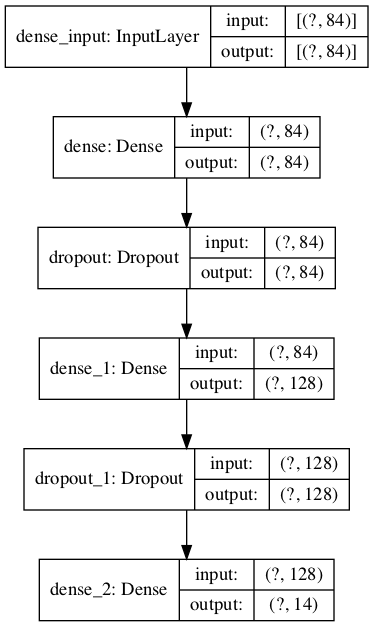

In [22]:
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import  plot_model
from IPython.display import SVG
plot_model(nn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 84)                7140      
_________________________________________________________________
dropout (Dropout)            (None, 84)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                1

scrap

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[labels[i]], tpr[labels[i]], _ = roc_curve(test_Y_num[:,i])